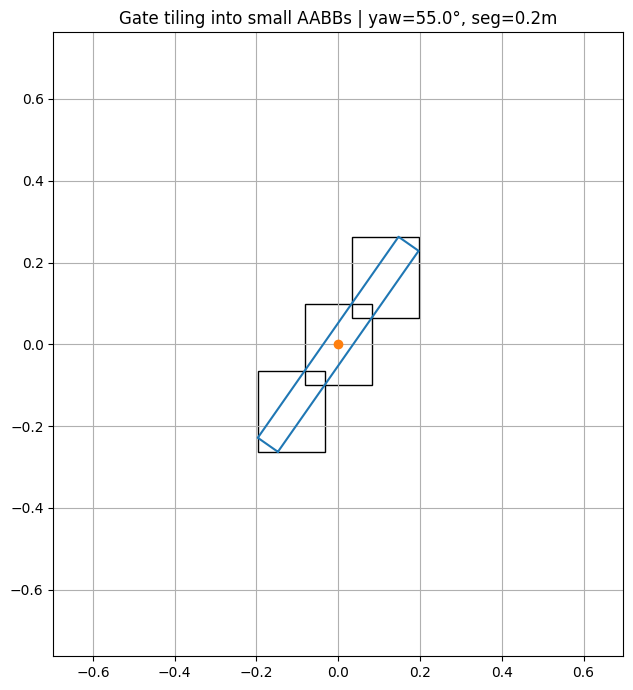

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def gate_tiles_aabbs(cx, cy, yaw, gate_width=1.0, thickness=0.05, segment_length=0.2):
    """
    返回：
      - tiles: 小 AABB 列表 (xmin, ymin, xmax, ymax)
      - obb_world: 真实旋转门板四个角点 (4,2)（用于对照画轮廓）
    """
    half_w = gate_width / 2
    num_seg = max(1, int(np.ceil(gate_width / segment_length)))
    xs = np.linspace(-half_w + segment_length/2, half_w - segment_length/2, num_seg)

    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[c, -s],
                  [s,  c]])

    # 真实门板(OBB)角点（门自身坐标系）
    obb_local = np.array([
        [-half_w, -thickness],
        [-half_w,  thickness],
        [ half_w,  thickness],
        [ half_w, -thickness],
    ])
    obb_world = obb_local @ R.T + np.array([cx, cy])

    tiles = []
    for x_local in xs:
        corners_local = np.array([
            [x_local - segment_length/2, -thickness],
            [x_local - segment_length/2,  thickness],
            [x_local + segment_length/2,  thickness],
            [x_local + segment_length/2, -thickness],
        ])
        pts = corners_local @ R.T + np.array([cx, cy])
        xmin, ymin = pts.min(axis=0)
        xmax, ymax = pts.max(axis=0)
        tiles.append((xmin, ymin, xmax, ymax))

    return tiles, obb_world

def visualize_gate_tiling(cx=0.0, cy=0.0, yaw=np.deg2rad(55),
                          gate_width=0.6, thickness=0.03, segment_length=0.1,
                          margin=0.5, save_path="gate_tiling_demo.png"):
    tiles, obb_world = gate_tiles_aabbs(cx, cy, yaw, gate_width, thickness, segment_length)

    fig, ax = plt.subplots(figsize=(7, 7))

    # 小 AABB tiles
    for (xmin, ymin, xmax, ymax) in tiles:
        ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False))

    # 真实 OBB 轮廓（闭合线）
    obb_closed = np.vstack([obb_world, obb_world[0]])
    ax.plot(obb_closed[:, 0], obb_closed[:, 1])

    # 中心点
    ax.plot([cx], [cy], marker="o")

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)
    ax.set_title(f"Gate tiling into small AABBs | yaw={np.rad2deg(yaw):.1f}°, seg={segment_length}m")

    # 自动设置范围
    all_x, all_y = [cx], [cy]
    all_x += list(obb_world[:, 0]); all_y += list(obb_world[:, 1])
    for (xmin, ymin, xmax, ymax) in tiles:
        all_x += [xmin, xmax]; all_y += [ymin, ymax]
    ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
    ax.set_ylim(min(all_y) - margin, max(all_y) + margin)

    fig.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.show()

if __name__ == "__main__":
    visualize_gate_tiling()
